# Amazon SageMaker と AutoGluon を用いた画像分類モデルの学習と推論

Amazon SageMaker Notebook Instance の ml.m5.2xlarge インスタンスで動作検証しています。

## 0. 事前準備

### 0.1. OpenCV のインストール

画像処理ライブラリである OpenCV をインストールし、AutoGluon の依存関係を解決する。

In [2]:
#!yum update &&  install -y python3-opencv tree

### 0.2. AutoGluon のインストール

AutoML ライブラリである AutoGluon をインストール。
最新のインストールコマンドは https://auto.gluon.ai/dev/index.html を参照のこと。

In [3]:
# 2022年8月30日現在のインストールコマンド
!pip3 install -U pip
!pip3 install -U setuptools wheel

# CPU version of pytorch has smaller footprint - see installation instructions in
# pytorch documentation - https://pytorch.org/get-started/locally/
!pip3 install torch==1.12+cpu torchvision==0.13.0+cpu torchtext==0.13.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html

!pip3 install --pre autogluon.core autogluon.vision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.4 MB/s eta 0:00:00:00:01
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.0
    Uninstalling wheel-0.37.0:
      Successfully uninstalled wheel-0.37.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.4.0
    Uninstalling setuptools-59.4.0:
      Successfully uninstalled setuptools-59.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

### 0.3. MNIST-JPG をダウンロード

サンプルデータセットとして JPG 形式の手書き数字データセット (MNIST) をダウンロード。
https://github.com/teavanist/MNIST-JPG

In [4]:
!wget https://github.com/teavanist/MNIST-JPG/raw/master/MNIST%20Dataset%20JPG%20format.zip

--2022-08-29 08:10:46--  https://github.com/teavanist/MNIST-JPG/raw/master/MNIST%20Dataset%20JPG%20format.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/teavanist/MNIST-JPG/master/MNIST%20Dataset%20JPG%20format.zip [following]
--2022-08-29 08:10:46--  https://raw.githubusercontent.com/teavanist/MNIST-JPG/master/MNIST%20Dataset%20JPG%20format.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52766564 (50M) [application/zip]
Saving to: ‘MNIST Dataset JPG format.zip’

100%[======================================>] 52,766,564  --.-K/s   in 0.1s    

2022-08-29 08:10:47 (341 MB/s) - ‘MNIST Data

In [7]:
from zipfile import ZipFile

with ZipFile('./MNIST Dataset JPG format.zip', 'r') as f:
    f.extractall()

In [9]:
import tarfile

with tarfile.open('train.tar.gz', 'w:gz') as f:
    f.add('MNIST Dataset JPG format/MNIST - JPG - training', arcname='.')

with tarfile.open('test.tar.gz', 'w:gz') as f:
    f.add('MNIST Dataset JPG format/MNIST - JPG - testing', arcname='.')

### 0.4. SageMaker Python SDK のアップデート

In [ ]:
!pip install -U sagemaker boto3

### 0.5. SageMaker で使う変数の準備

In [1]:
from pprint import pprint

import boto3
import sagemaker
from sagemaker import get_execution_role

sm_session = sagemaker.Session()
bucket = sm_session.default_bucket()
region = boto3.Session().region_name
role = get_execution_role()

pprint({'bucket': bucket, 'region': region, 'role': role})

{'bucket': 'sagemaker-us-east-1-809078683005',
 'region': 'us-east-1',
 'role': 'arn:aws:iam::809078683005:role/service-role/AmazonSageMaker-ExecutionRole-20210111T174819'}


## 1. データセットの準備

### 1.1. Amazon S3 へデータセットをアップロード

MNIST の計7万枚の画像を個別にアップロードすると時間がかかるので Gzip 圧縮してからアップロードします。

In [3]:
from sagemaker.s3 import S3Uploader

train_data_uri = S3Uploader.upload(
    local_path='train.tar.gz',
    desired_s3_uri=f's3://{bucket}/mnist_jpg/train',
)
_ = S3Uploader.upload(
    local_path='MNIST Dataset JPG format/MNIST - JPG - testing/0/10.jpg',
    desired_s3_uri=f's3://{bucket}/mnist_jpg/inference',
)
_ = S3Uploader.upload(
    local_path='MNIST Dataset JPG format/MNIST - JPG - testing/1/1004.jpg',
    desired_s3_uri=f's3://{bucket}/mnist_jpg/inference',
)
pprint({'train_data_uri': train_data_uri})

{'train_data_uri': 's3://sagemaker-us-east-1-809078683005/mnist_jpg/train/train.tar.gz'}


## 2. 画像分類モデルの学習 - ローカル環境

まず、何をやっているかを把握するために AutoGluon をローカルで動かして画像分類モデルの学習を行います。

`ImageDataset` クラスでデータセットを準備し、`ImagePredictor` クラスでモデルの学習を行います。

In [60]:
import autogluon.core as ag
from autogluon.vision import (
    ImageDataset,
    ImagePredictor,
)

### 2.1 データセットを ImageDataset で読み込み

`ImageDataset.from_folder` メソッドを使うと、フォルダの名前をラベルとみなして、画像のパスとラベルをテーブル形式で取得できます。
https://auto.gluon.ai/dev/tutorials/image_prediction/dataset.html

In [61]:
train_data = ImageDataset.from_folder('MNIST Dataset JPG format/MNIST - JPG - training')
test_data = ImageDataset.from_folder('MNIST Dataset JPG format/MNIST - JPG - testing')

In [7]:
train_data

,image,label
0,/home/ec2-user/SageMaker/work/autogluon-vision...,0
1,/home/ec2-user/SageMaker/work/autogluon-vision...,0
2,/home/ec2-user/SageMaker/work/autogluon-vision...,0
3,/home/ec2-user/SageMaker/work/autogluon-vision...,0
4,/home/ec2-user/SageMaker/work/autogluon-vision...,0
...,...,...
59995,/home/ec2-user/SageMaker/work/autogluon-vision...,9
59996,/home/ec2-user/SageMaker/work/autogluon-vision...,9
59997,/home/ec2-user/SageMaker/work/autogluon-vision...,9
59998,/home/ec2-user/SageMaker/work/autogluon-vision...,9


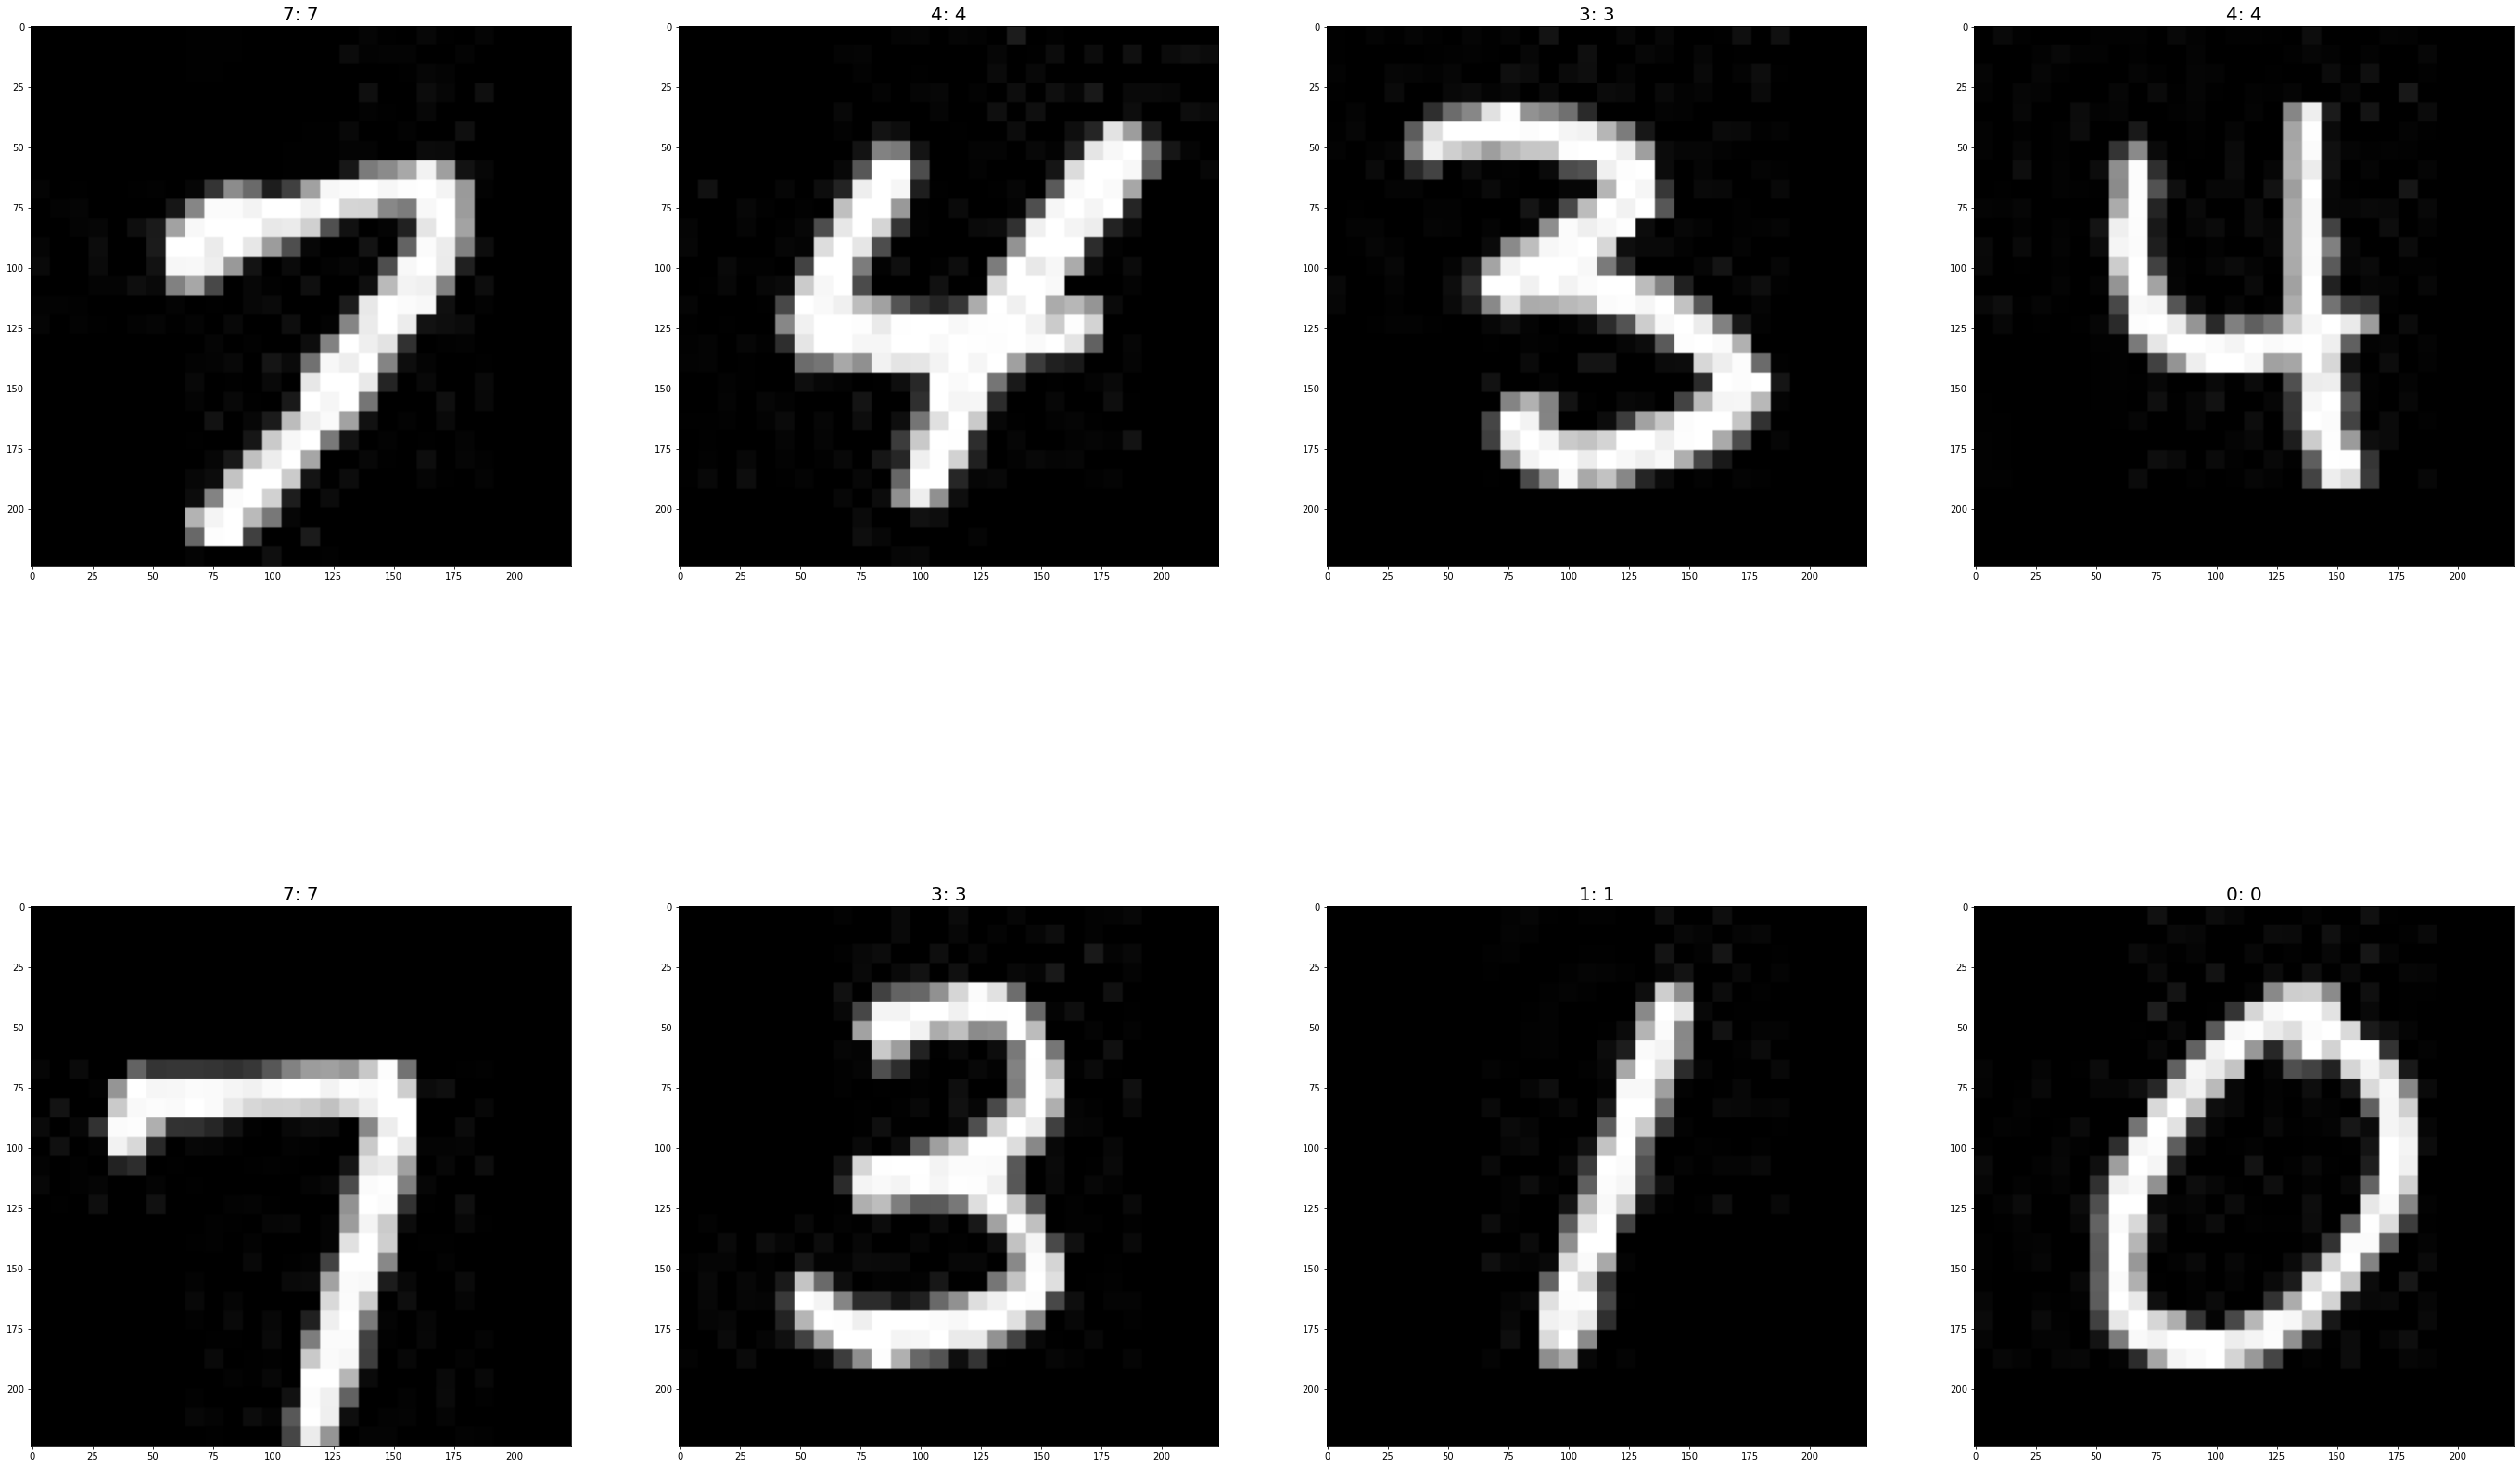

In [8]:
train_data.show_images(nsample=8)

In [9]:
test_data

,image,label
0,/home/ec2-user/SageMaker/work/autogluon-vision...,0
1,/home/ec2-user/SageMaker/work/autogluon-vision...,0
2,/home/ec2-user/SageMaker/work/autogluon-vision...,0
3,/home/ec2-user/SageMaker/work/autogluon-vision...,0
4,/home/ec2-user/SageMaker/work/autogluon-vision...,0
...,...,...
9995,/home/ec2-user/SageMaker/work/autogluon-vision...,9
9996,/home/ec2-user/SageMaker/work/autogluon-vision...,9
9997,/home/ec2-user/SageMaker/work/autogluon-vision...,9
9998,/home/ec2-user/SageMaker/work/autogluon-vision...,9


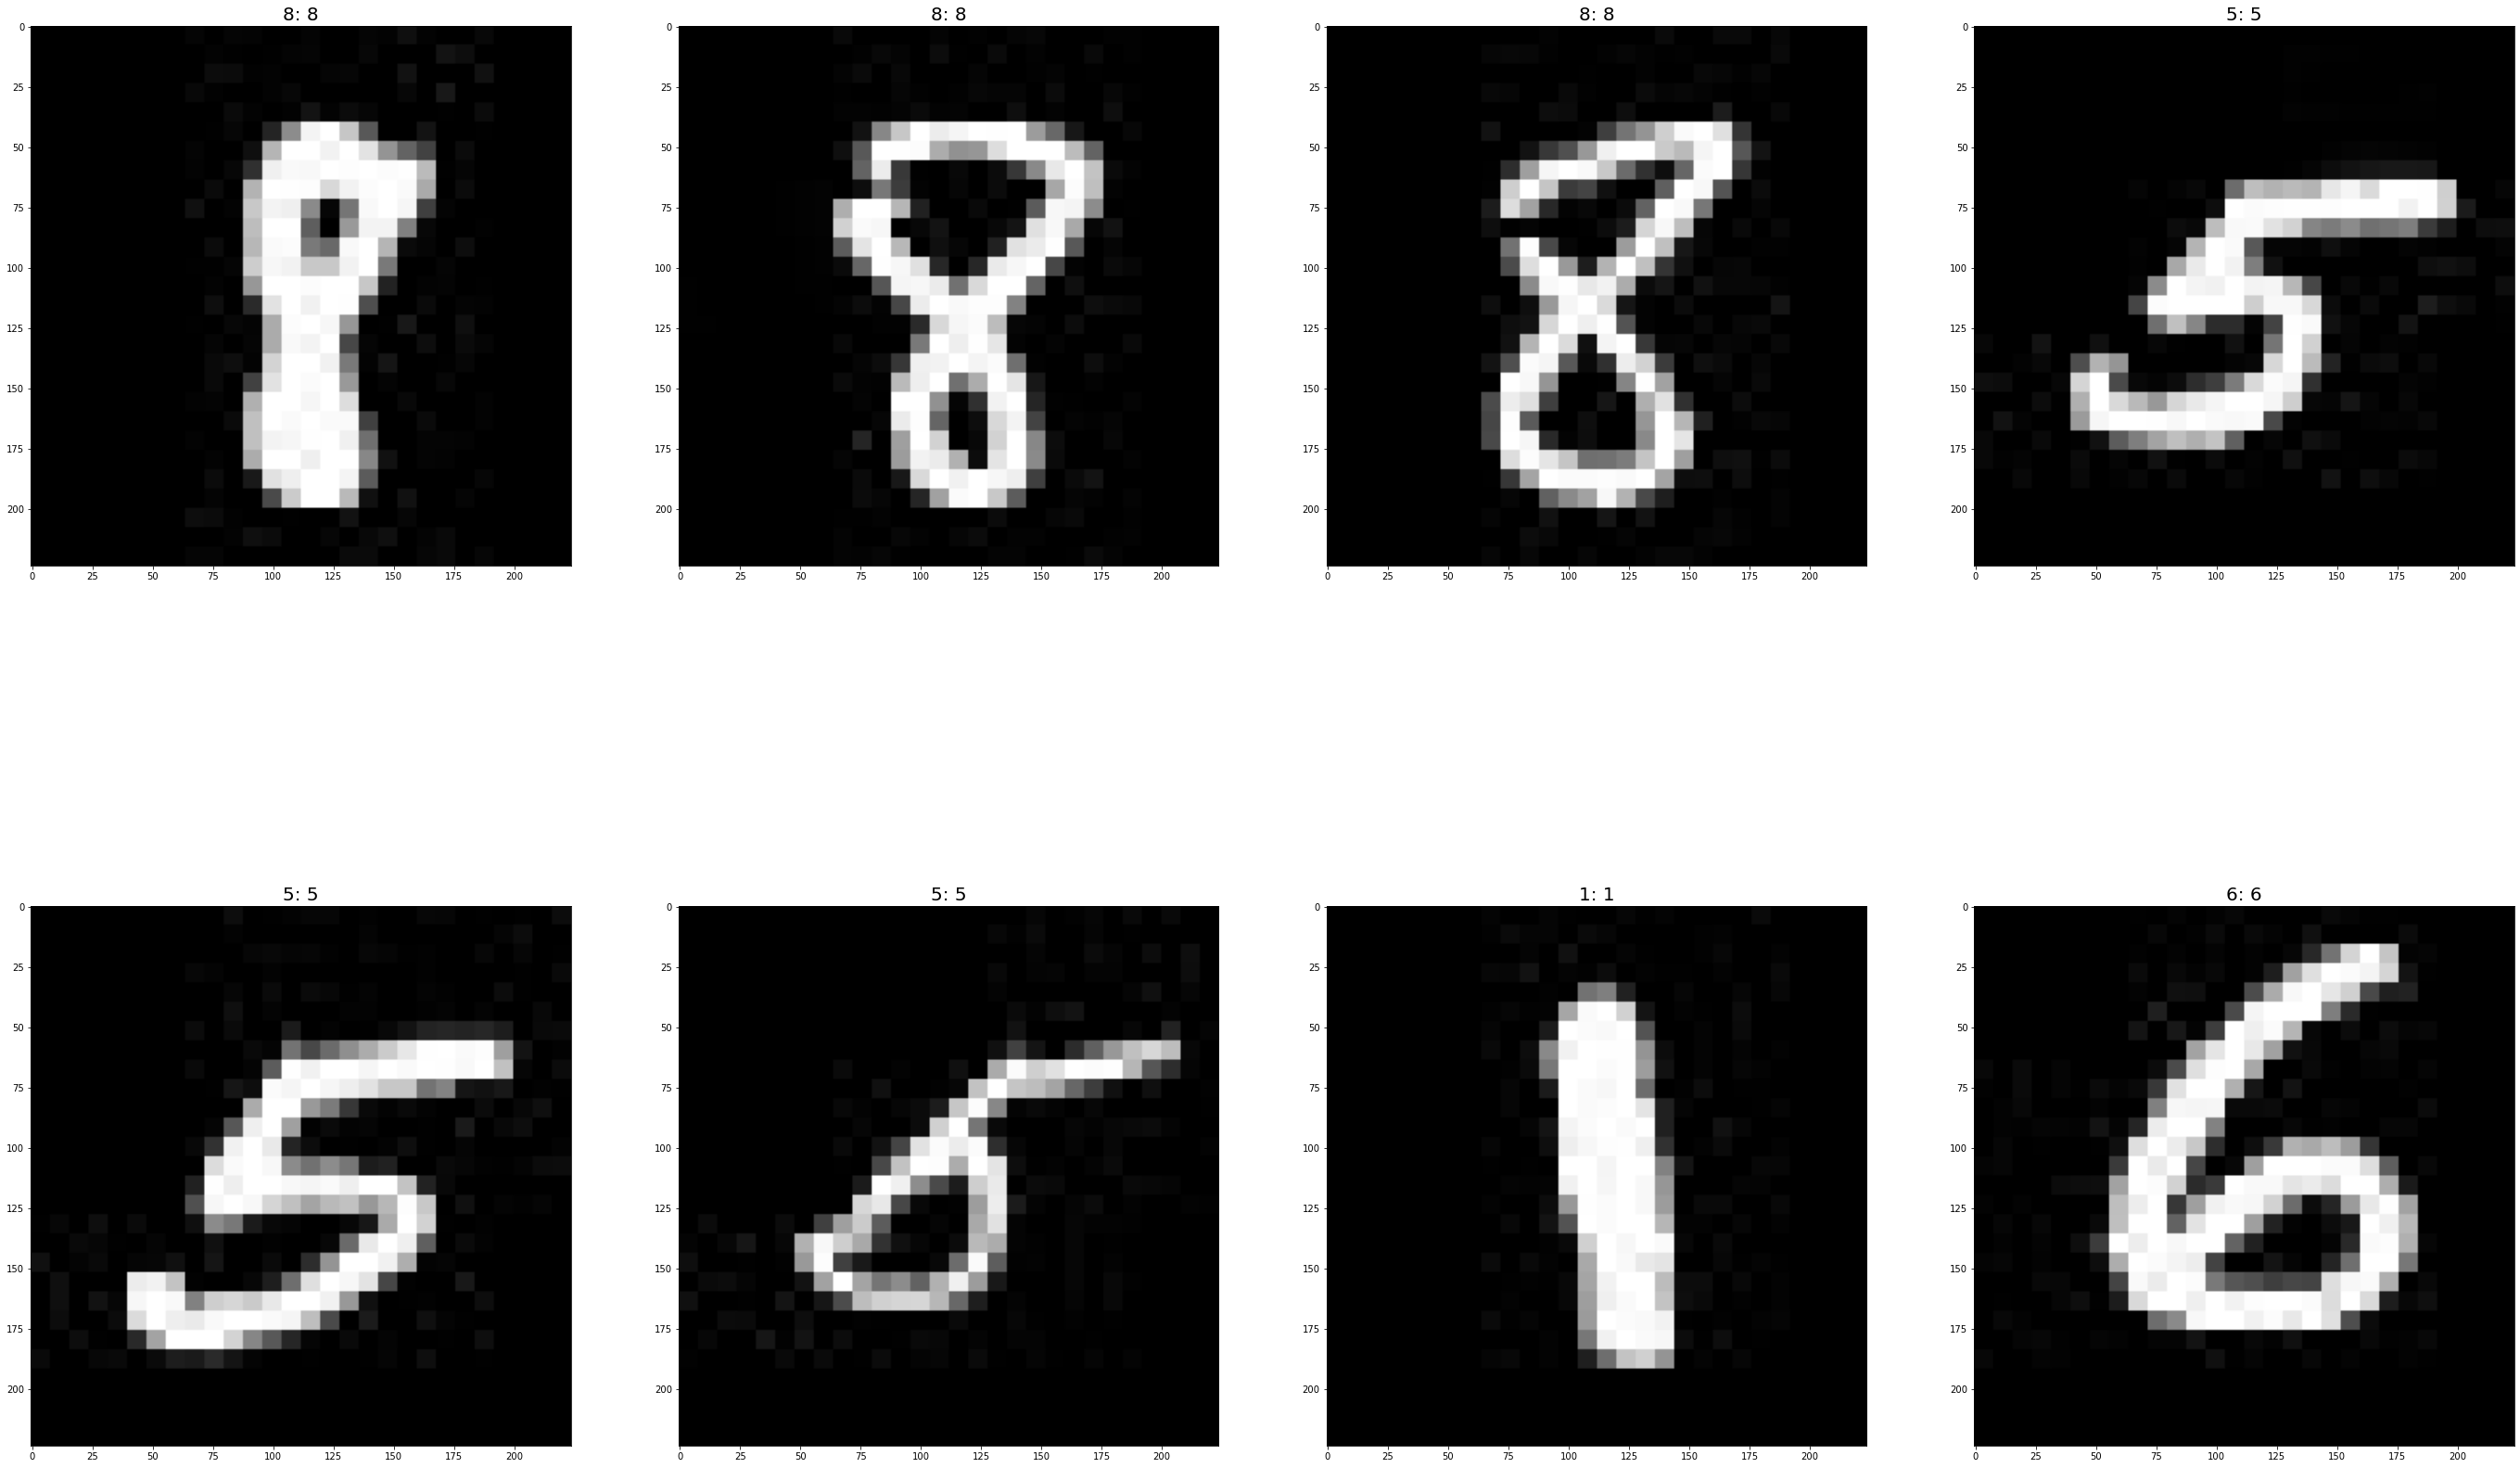

In [10]:
test_data.show_images(nsample=8)

### 2.2 学習時間短縮のためデータセットをサンプリング

AutoGluon のデモ用途で学習するだけなので、学習データは10%にサンプリングします。

In [ ]:
train_data_sampled = train_data.sample(frac=0.1, random_state=42)

### 2.3 ImagePredictor で学習を実行

`ImagePredictor` の `.fit` メソッドに学習データを渡してあげればモデルの学習が行われます。

In [17]:
predictor = ImagePredictor()
# since the original dataset does not provide validation split, the `fit` function splits it randomly with 90/10 ratio
predictor.fit(train_data_sampled, hyperparameters={'epochs': 2})  # you can trust the default config, we reduce the # epoch to save some build time

ImagePredictor sets accuracy as default eval_metric for classification problems.
`time_limit=auto` set to `time_limit=7200`.
Reset labels to [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Randomly split train_data into train[5400]/validation[600] splits.
No GPU detected/allowed, using most conservative search space.
Starting fit without HPO
modified configs(<old> != <new>): {
root.gpus            (0,) != ()
root.train.early_stop_max_value 1.0 != inf
root.train.batch_size 32 != 16
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 2
root.train.early_stop_patience -1 != 10
root.img_cls.model   resnet101 != resnet18
root.misc.seed       42 != 688
root.misc.num_workers 4 != 8
}
Saved config to /home/ec2-user/SageMaker/work/autogluon-vision-on-sagemaker/6550ba50/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] 

`predictor.fit_summary()` メソッドで学習結果とハイパーパラメータが取得できます。

In [19]:
fit_result = predictor.fit_summary()

In [20]:
fit_result

{'train_acc': 0.6958456973293768,
 'valid_acc': 0.9366666666666666,
 'total_time': 394.73853158950806,
 'best_config': {'model': 'resnet18',
  'lr': 0.01,
  'epochs': 2,
  'batch_size': 16,
  'nthreads_per_trial': 32,
  'ngpus_per_trial': 0,
  'time_limits': 7200,
  'dist_ip_addrs': None,
  'searcher': 'random',
  'early_stop_patience': 10,
  'early_stop_baseline': -inf,
  'early_stop_max_value': inf,
  'num_workers': 8,
  'gpus': [],
  'seed': 688,
  'final_fit': False},
 'fit_history': {'train_acc': 0.6958456973293768,
  'valid_acc': 0.9366666666666666,
  'total_time': 394.73853158950806,
  'best_config': {'model': 'resnet18',
   'lr': 0.01,
   'epochs': 2,
   'batch_size': 16,
   'nthreads_per_trial': 32,
   'ngpus_per_trial': 0,
   'time_limits': 7200,
   'dist_ip_addrs': None,
   'searcher': 'random',
   'early_stop_patience': 10,
   'early_stop_baseline': -inf,
   'early_stop_max_value': inf,
   'num_workers': 8,
   'gpus': [],
   'seed': 688,
   'final_fit': False}}}

`predictor.predict()` メソッドにデータセットを渡せば、学習したモデルで推論を行うことができます。

In [26]:
bulk_result = predictor.predict(test_data.sample(frac=0.1, random_state=42))
bulk_result

6252    6
4684    4
1731    1
4742    4
4521    4
       ..
3921    3
6685    6
3194    3
1941    1
7713    7
Name: label, Length: 1000, dtype: int64

In [94]:
type(bulk_result)

pandas.core.series.Series

`predictor.evaluate()` メソッドにラベル付きのデータセットを渡せば、そのデータセットに対する精度を評価することができます。

In [25]:
test_acc = predictor.evaluate(test_data.sample(frac=0.1, random_state=42))

[Epoch 1] validation: top1=0.937000 top5=0.999000


## 3. 学習 - SageMaker Training Job

ローカルでなく、パワフルなサーバーインスタンスでバッチ的に学習を実行します。

In [17]:
from scripts.ag_model import (
    AutoGluonTraining,
    AutoGluonVisionInferenceModel,
    AutoGluonVisionPredictor,
)
ag = AutoGluonTraining(
    role=role,
    entry_point="scripts/train.py",
    region=region,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    #instance_type='local',
    framework_version="0.4",
    py_version="py38",
    base_job_name="autogluon-vision-train",
    hyperparameters={
        'epochs': 1,
        'batch-size': 64,
        'frac': 0.05,
        'random-state': 42,
    },
)

In [18]:
ag.fit({'training': train_data_uri})

2022-08-30 01:43:24 Starting - Starting the training job...
2022-08-30 01:43:47 Starting - Preparing the instances for trainingProfilerReport-1661823804: InProgress
......
2022-08-30 01:44:48 Downloading - Downloading input data...
2022-08-30 01:45:17 Training - Downloading the training image........2022-08-30 01:46:30,030 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-08-30 01:46:30,032 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-08-30 01:46:30,040 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":64,"epochs":1,"frac":0.05,"random-state":42}', 'SM_USER_ENTRY_POINT': 'train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_group_name":"homogeneousCluster","current_host":"algo-1","current_instance_type":"ml.m5.2xlarge","hosts":["algo-1"],"instance_groups":[{"hosts":["alg

出来上がったモデルで `Model` オブジェクトを作成します。

In [70]:
model = AutoGluonVisionInferenceModel(
    model_data=ag.model_data,
    role=role,
    region=region,
    framework_version="0.4",
    py_version="py38",
    instance_type=inference_instance_type,
    entry_point="scripts/vision_serve.py",
)

AttributeError: module 'autogluon.core' has no attribute 'model_data'

`.deploy()` メソッドで REST エンドポイントをデプロイできます。

In [87]:
from sagemaker.serializers import CSVSerializer, NumpySerializer
from sagemaker.deserializers import JSONDeserializer
predictor = model.deploy(
    initial_instance_count=1,
    #instance_type=inference_instance_type,
    instance_type='local',
    serializer=NumpySerializer(),
    deserializer=JSONDeserializer(),
)

Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fa559aeef70>: Failed to establish a new connection: [Errno 111] Connection refused')': /ping
Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fa559adab20>: Failed to establish a new connection: [Errno 111] Connection refused')': /ping
Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fa559adabe0>: Failed to establish a new connection: [Errno 111] Connection refused')': /ping


Attaching to 0q042ulnzg-algo-1-pycg7
0q042ulnzg-algo-1-pycg7 | Warning: MMS is using non-default JVM parameters: -XX:-UseContainerSupport
0q042ulnzg-algo-1-pycg7 | 2022-08-30T02:56:23,749 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
0q042ulnzg-algo-1-pycg7 | MMS Home: /usr/local/lib/python3.8/dist-packages
0q042ulnzg-algo-1-pycg7 | Current directory: /
0q042ulnzg-algo-1-pycg7 | Temp directory: /home/model-server/tmp
0q042ulnzg-algo-1-pycg7 | Number of GPUs: 0
0q042ulnzg-algo-1-pycg7 | Number of CPUs: 8
0q042ulnzg-algo-1-pycg7 | Max heap size: 7033 M
0q042ulnzg-algo-1-pycg7 | Python executable: /usr/bin/python3
0q042ulnzg-algo-1-pycg7 | Config file: /etc/sagemaker-mms.properties
0q042ulnzg-algo-1-pycg7 | Inference address: http://0.0.0.0:8080
0q042ulnzg-algo-1-pycg7 | Management address: http://0.0.0.0:8080
0q042ulnzg-algo-1-pycg7 | Model Store: /.sagemaker/mms/models
0q042ulnzg-algo-1-pycg7 | Initial Models: ALL
0q042ulnzg-algo-1-pycg7 | Log dir: null
0q042ulnzg-algo-1-pycg7 | Metr

推論は `predictor.predict()` メソッドで実行できます。

In [88]:
from PIL import Image
import numpy as np
from sagemaker.serializers import NumpySerializer, CSVSerializer
data = np.array(Image.open('MNIST Dataset JPG format/MNIST - JPG - testing/0/10.jpg'))
#predictor.serializer = CSVSerializer()
#predictor.deserializer = sagemaker.deserializers.StreamDeserializer()
response = predictor.predict(data)

0q042ulnzg-algo-1-pycg7 | 2022-08-30T02:56:31,024 [INFO ] W-model-3-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - *****request_body*****
0q042ulnzg-algo-1-pycg7 | 2022-08-30T02:56:31,025 [INFO ] W-model-3-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - <class 'bytearray'>
0q042ulnzg-algo-1-pycg7 | 2022-08-30T02:56:31,026 [INFO ] W-model-3-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - bytearray(b"\x93NUMPY\x01\x00v\x00{\'descr\': \'|u1\', \'fortran_order\': False, \'shape\': (28, 28), }                                                        \n\x00\x00\x00\x00\x00\x00\x00\x00\x0c\x00\t\x00\x01\x01\x01\x00\x00\x05\x04\x00\x00\x00\x02\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n\x00\x05\x00\x08\x04\x03\x03\x00\x0c\x06\x00\n\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x15\x00\x00\x03\x00\x06\x00\x02\x01\x00\x00\x00\x07\x00\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x15\x00\x00\x08\t\r\x00\x0b\x03\x10\x00\x15\x00\x00\x00\x00\x00\x00

In [89]:
print(response)

[3]
